# **Important Libraries**

In [1]:
import pandas as pd
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.model_selection import train_test_split
import tifffile as tiff
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation
import albumentations as A

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# **Prepare Dataset**

In [2]:
# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
NUM_CHANNELS = 12
BATCH_SIZE = 16

In [3]:
img_dir = "/content/drive/MyDrive/data/images"
mask_dir = "/content/drive/MyDrive/data/labels"

In [4]:
len(os.listdir(img_dir)),len(os.listdir(mask_dir))

(306, 456)

In [5]:
# Collect images and masks
images = [os.path.join(img_dir,file) for file in os.listdir(img_dir) if file.endswith('.tif')]
masks = [os.path.join(mask_dir,file) for file in os.listdir(mask_dir) if file.endswith('.png')]

# Create dictionaries to match images with masks
image_names = {os.path.splitext(os.path.basename(img))[0]: img for img in images}
mask_names = {os.path.splitext(os.path.basename(mask))[0]: mask for mask in masks}

# Find common keys
common_keys = sorted(set(image_names) & set(mask_names))

# Ensure only matching images and masks are used
images = [image_names[key] for key in common_keys]
masks = [mask_names[key] for key in common_keys]

print(f"Found {len(images)} matching image-mask pairs.")

Found 306 matching image-mask pairs.


In [6]:
# Create DataFrame
df = pd.DataFrame({"images": images, "masks": masks})
df.head()

,images,masks
0,/content/drive/MyDrive/data/images/0.tif,/content/drive/MyDrive/data/labels/0.png
1,/content/drive/MyDrive/data/images/1.tif,/content/drive/MyDrive/data/labels/1.png
2,/content/drive/MyDrive/data/images/10.tif,/content/drive/MyDrive/data/labels/10.png
3,/content/drive/MyDrive/data/images/100.tif,/content/drive/MyDrive/data/labels/100.png
4,/content/drive/MyDrive/data/images/101.tif,/content/drive/MyDrive/data/labels/101.png


Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)
Sample image shape: (128, 128, 12)


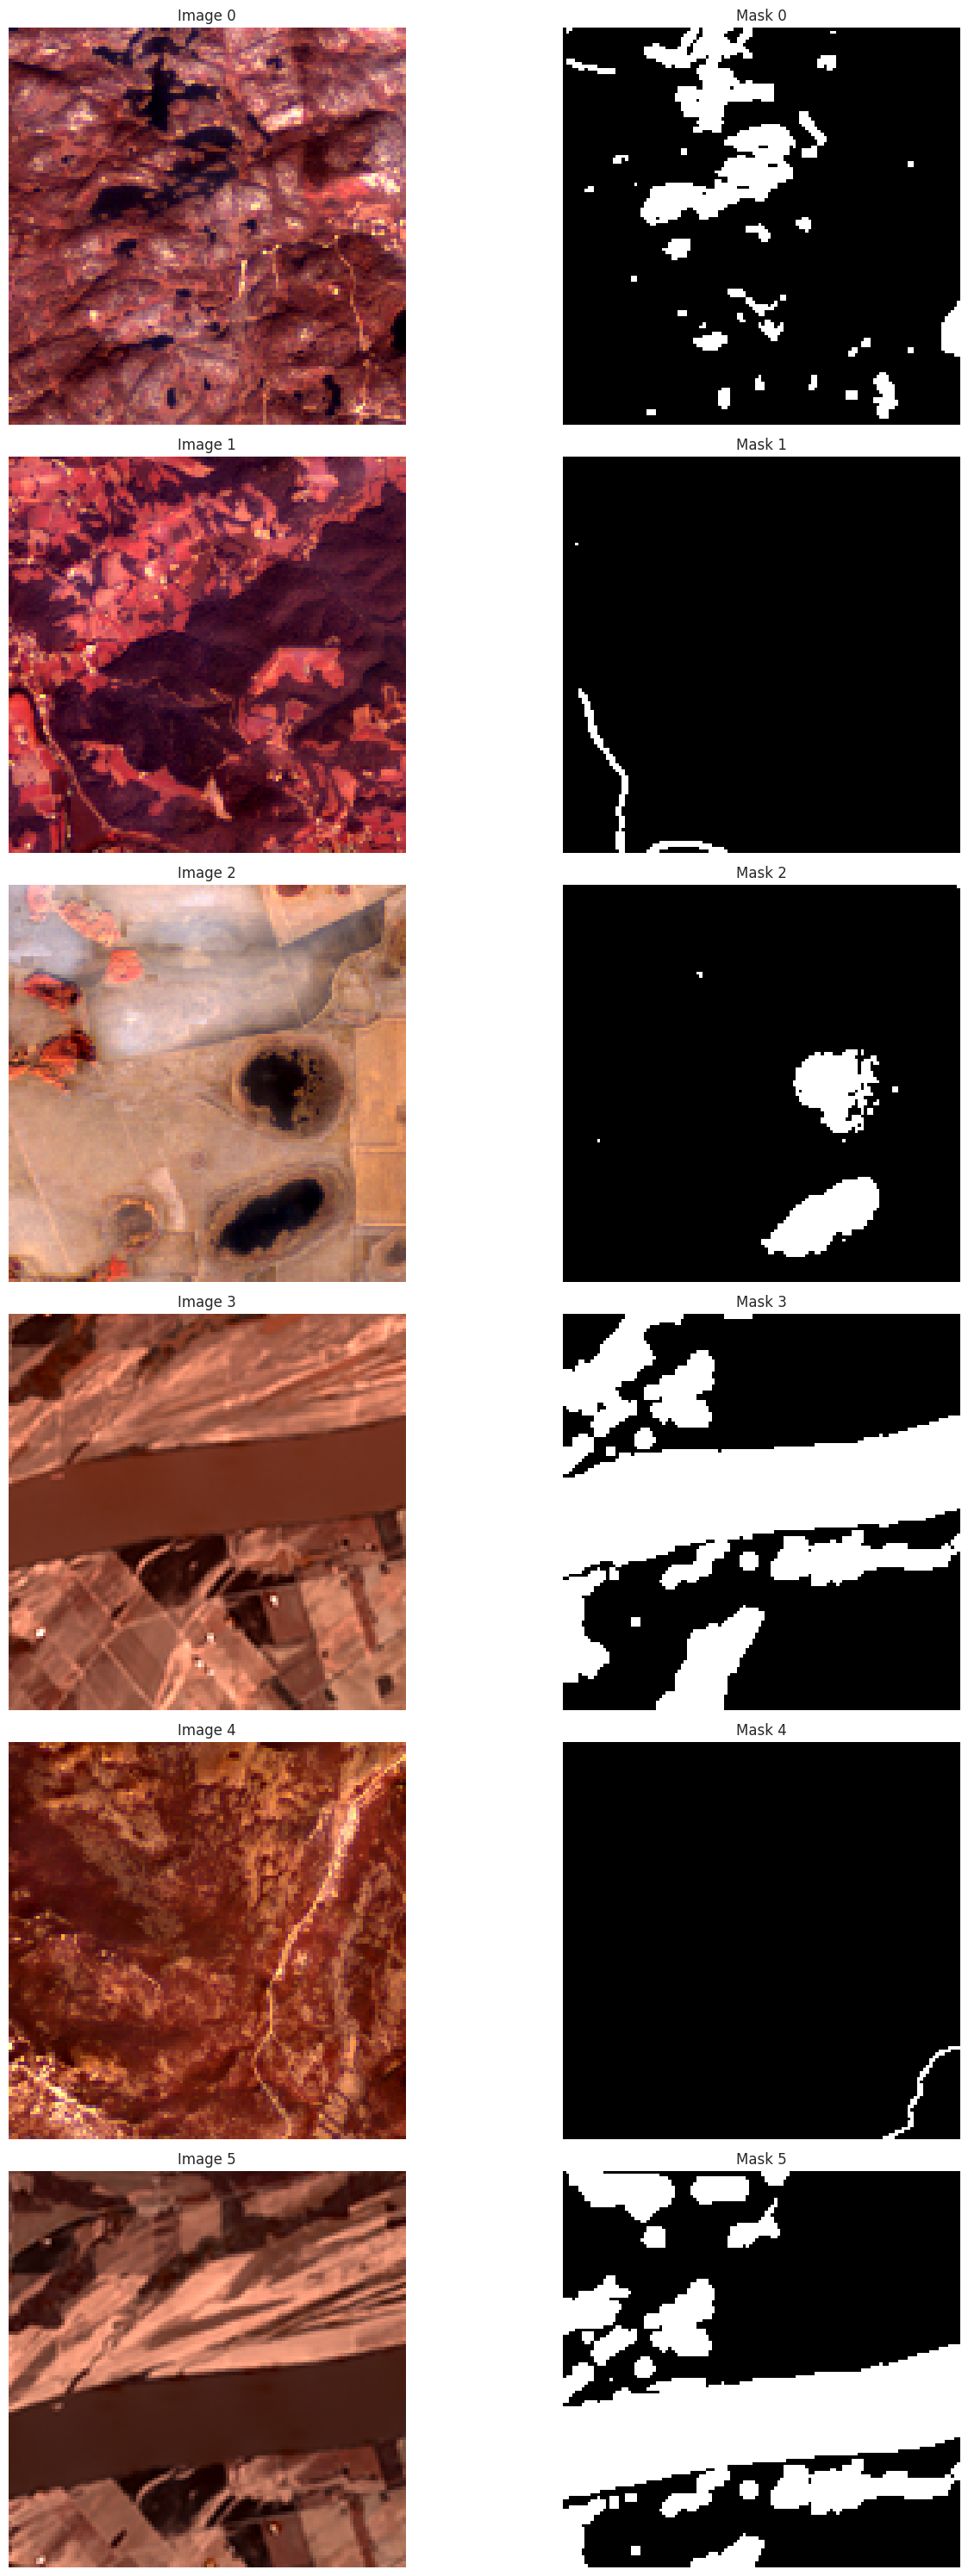

In [7]:
# Visualization
def visualize_image_mask_pairs(df, num_samples=6):
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        # Load image and mask paths
        img_path = df['images'].iloc[i]
        mask_path = df['masks'].iloc[i]

        # Read full multi-channel image
        img_full = tiff.imread(img_path)
        print(f"Sample image shape: {img_full.shape}")

        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if len(img_full.shape) == 3 and img_full.shape[2] >= 3:
            img_rgb_vis = img_full[:, :, [2, 1, 0]]
            # Normalize for better display contrast
            pmin, pmax = np.percentile(img_rgb_vis, (0.5, 99.5))
            img_rgb_vis = np.clip(img_rgb_vis, pmin, pmax)
            img_rgb_vis = ((img_rgb_vis - pmin) / (pmax - pmin + 1e-8) * 255).astype(np.uint8)
        elif len(img_full.shape) == 2:
             img_rgb_vis = cv2.cvtColor(img_full, cv2.COLOR_GRAY2RGB)
        else:
             # Fallback if less than 3 channels
             print(f"Warning: Image {img_path} has {img_full.shape[-1]} channels, cannot create RGB.")
             img_rgb_vis = np.zeros((img_full.shape[0], img_full.shape[1], 3), dtype=np.uint8)


        # Ensure correct display size
        if img_rgb_vis.shape[0] != IMG_HEIGHT or img_rgb_vis.shape[1] != IMG_WIDTH:
            img_rgb_vis = cv2.resize(img_rgb_vis, (IMG_WIDTH, IMG_HEIGHT))
        if mask.shape[0] != IMG_HEIGHT or mask.shape[1] != IMG_WIDTH:
             mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)


        # Plot image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(img_rgb_vis)
        plt.title(f'Image {i}')
        plt.axis('off')

        # Plot mask
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize to check
visualize_image_mask_pairs(df)

In [8]:
# Split the dataset
def split_df(df):
    train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=42)
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=42)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = split_df(df)
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(valid_df)} samples")
print(f"Test set: {len(test_df)} samples")

Training set: 244 samples
Validation set: 31 samples
Test set: 31 samples


# **Image Data Generator**

In [9]:
def load_and_preprocess(img_path, mask_path):
    # Load .tif image
    img = tiff.imread(img_path)

    # Load .png mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Ensure correct data types
    img = img.astype(np.float32)
    mask = mask.astype(np.float32)

    # Ensure mask has channel dimension for consistency
    mask = np.expand_dims(mask, axis=-1)

    return img, mask

In [10]:
def apply_augmentation(image, mask, aug_params):
    """
    Apply augmentation to both image and mask using albumentations.
    image: (height, width, channels)
    mask: (height, width, 1)
    aug_params: dictionary with augmentation parameters
    """
    # Define augmentation pipeline
    transform = A.Compose([
        A.Rotate(limit=aug_params.get('rotation_range', 0), p=0.5, border_mode=cv2.BORDER_REFLECT),
        A.HorizontalFlip(p=0.5 if aug_params.get('horizontal_flip', False) else 0),
        A.VerticalFlip(p=0.5 if aug_params.get('vertical_flip', False) else 0),
        A.Affine(
            scale=(1 - aug_params.get('zoom_range', 0), 1 + aug_params.get('zoom_range', 0)),
            shear=(-aug_params.get('shear_range', 0) * 180/np.pi, aug_params.get('shear_range', 0) * 180/np.pi),
            translate_percent={
                'x': (-aug_params.get('width_shift_range', 0), aug_params.get('width_shift_range', 0)),
                'y': (-aug_params.get('height_shift_range', 0), aug_params.get('height_shift_range', 0))
            },
            p=0.5,
            mode=cv2.BORDER_REFLECT
        )
    ])

    # Apply augmentations
    augmented = transform(image=image, mask=mask)

    # Extract augmented image and mask
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    # Ensure mask remains binary (0 or 1)
    augmented_mask = (augmented_mask > 0.5).astype(np.float32)

    return augmented_image, augmented_mask

In [11]:
def create_gens(df, aug_dict=None, batch_size=BATCH_SIZE):
    """
    Create a generator for images and masks.
    df: DataFrame with 'images' and 'masks' columns
    aug_dict: Dictionary with augmentation parameters (or None for no augmentation)
    batch_size: Number of samples per batch
    """
    while True:
        # Shuffle DataFrame
        df = df.sample(frac=1).reset_index(drop=True)
        for start in range(0, len(df), batch_size):
            end = min(start + batch_size, len(df))
            batch_images = []
            batch_masks = []

            for i in range(start, end):
                # Load image and mask
                img_path = df['images'].iloc[i]
                mask_path = df['masks'].iloc[i]

                # Read image (assuming TIFF with 12 channels)
                img = tiff.imread(img_path)
                # Read mask (assuming PNG with 1 channel)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)[..., np.newaxis] / 255.0

                # Resize to target size
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)[..., np.newaxis]

                # Apply augmentation if provided
                if aug_dict:
                    img, mask = apply_augmentation(img, mask, aug_dict)

                batch_images.append(img)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)

In [12]:
# Define enhanced augmentation parameters for training
tr_aug_dict = {
    'rotation_range': 20,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1,
    'horizontal_flip': True,
    'vertical_flip': True,
    'zoom_range': 0.1,
    'shear_range': 0.1
}

# Create generators
print("Creating data generators...")
train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict=None)
test_gen = create_gens(test_df, aug_dict=None)

# --- Test the Generator ---
print("Testing generator output shapes...")
# Get a batch
test_batch_imgs, test_batch_msks = next(train_gen)
print(f"Batch Images shape: {test_batch_imgs.shape}")
print(f"Batch Masks shape: {test_batch_msks.shape}")
print(f"Sample Image Min/Max: {test_batch_imgs[0].min():.4f} / {test_batch_imgs[0].max():.4f}")
print(f"Sample Mask Unique Values: {np.unique(test_batch_msks[0])}")

Creating data generators...
Testing generator output shapes...
Batch Images shape: (16, 128, 128, 12)
Batch Masks shape: (16, 128, 128, 1)
Sample Image Min/Max: 0.0000 / 4880.0000
Sample Mask Unique Values: [0.]


# **Model & Evaluation**

In [13]:
def unet(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder (Downsampling Path)
    # Block 1
    conv1 = Conv2D(64, (3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(64, (3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D((2, 2))(bn1)

    # Block 2
    conv2 = Conv2D(128, (3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(128, (3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D((2, 2))(bn2)

    # Block 3
    conv3 = Conv2D(256, (3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(256, (3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D((2, 2))(bn3)

    # Block 4
    conv4 = Conv2D(512, (3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(512, (3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D((2, 2))(bn4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(1024, (3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)

    # Decoder (Upsampling Path)
    # Block 6
    up6 = UpSampling2D((2, 2))(bn5)
    up6 = concatenate([up6, bn4])
    conv6 = Conv2D(512, (3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, (3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    # Block 7
    up7 = UpSampling2D((2, 2))(bn6)
    up7 = concatenate([up7, bn3])
    conv7 = Conv2D(256, (3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, (3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    # Block 8
    up8 = UpSampling2D((2, 2))(bn7)
    up8 = concatenate([up8, bn2])
    conv8 = Conv2D(128, (3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, (3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    # Block 9
    up9 = UpSampling2D((2, 2))(bn8)
    up9 = concatenate([up9, bn1])
    conv9 = Conv2D(64, (3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, (3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    model = Model(inputs, outputs)
    return model

In [14]:
def dice_coef(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

# Function to create dice loss
def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# Function to create IoU coefficient
def iou_coef(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum_ - intersection + smooth)
    return iou

In [15]:
model = unet()
model.compile(Adamax(learning_rate= 0.001), loss= dice_loss, metrics= ['accuracy', iou_coef, dice_coef])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]  

 Total params: 31,395,905 (119.77 MB)

 Trainable params: 31,390,017 (119.74 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [16]:
callbacks = [
    ModelCheckpoint('unet.h5', verbose=0, save_best_only=True),
    ]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_df) // BATCH_SIZE,
                    epochs=30,
                    verbose=1)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 175s 9s/step - accuracy: 0.6685 - dice_coef: 0.0011 - iou_coef: 0.0011 - loss: -0.0011
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.9681 - dice_coef: 0.0024 - iou_coef: 0.0024 - loss: -0.0024
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - accuracy: 0.9575 - dice_coef: 0.0038 - iou_coef: 0.0038 - loss: -0.0034
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 248ms/step - accuracy: 0.9663 - dice_coef: 0.0045 - iou_coef: 0.0045 - loss: -0.0037
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 258ms/step - accuracy: 0.9891 - dice_coef: 0.0061 - iou_coef: 0.0061 - loss: -0.0050
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step - accuracy: 0.9934 - dice_coef: 0.0064 - iou_coef: 0.0064 - loss: -0.0057
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - accuracy: 0.9915 - dice_coef: 0.0069 - iou_coef: 0.0069 - loss: -0.0062
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.9947 - dice_coef: 0.0078 - iou_coef: 0.0078 - loss: -

In [17]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 1.0000 - dice_coef: 0.2432 - iou_coef: 0.2432 - loss: -0.2432
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7687 - dice_coef: 0.1583 - iou_coef: 0.1579 - loss: -0.1583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.8124 - dice_coef: 0.1699 - iou_coef: 0.1695 - loss: -0.1699
Train Loss:  -0.24321946501731873
Train Accuracy:  1.0
Train IoU:  0.24321946501731873
Train Dice:  0.24321946501731873
--------------------
Valid Loss:  -0.15826304256916046
Valid Accuracy:  0.768707275390625
Valid IoU:  0.15785230696201324
Valid Dice:  0.15826304256916046
--------------------
Test Loss:  -0.1699153184890747
Test Accuracy:  0.8124351501464844
Test IoU:  0.16951267421245575
Test Dice:  0.1699153184890747
